# Lecture 6. Linear Regression, CV, Ridge and Lasso
--- 

### CS 109A/AC 209A/STAT 121A Data Science:
### Harvard University
Fall 2016 <br>
Instructors:  P. Protopapas, K. Rader, W. Pan




--- 

# Announcements 
 
- Grades are to 5 (with bonus 5.5) 
- Quiz policies:
    - Open books (you you only have 5 minutes/15 for DCE students once you open it.)
    - Do not share the secret code  
- Wednesday: Continue on linear regression  

- All lectures notes are now clean, corrected and no more spelin misaces 
    
---


In [1]:
# Quiz
import sys
import time

def countdown(n):
    #print("QUIZ TIME")
    for i in range(1*n,0,-1):
        time.sleep(1)
        sys.stdout.write(str(i)+' ')
        sys.stdout.flush()

--- 
# QUIZ TIME
{{countdown(0)}}
---

----

# Outline 
- Review and where we are heading
- Cross Validation
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso 


   

---  


----

# Outline 
- ** Review and where we are heading ** 
- Cross Validation
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso 


   

---  


In [2]:
#IMPORTS 
from IPython.display import Image
from ipywidgets import interact,  FloatSlider, RadioButtons
import numpy as np 
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as Lin_Reg

import itertools as it
import statsmodels.api as sm
import pandas as pd

In [3]:
# FONTS ETC 
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

---
## Review: The story so far 

- Start with data: (X,Y)
    - $n$ observations and $p$ predictors $X_{n\times p}$. $Y$ has $n$ observations.

- Fit the model using ordinary least square (OLS) as the lost function $L(\beta)= \sum_{i}^{n} (y_i - \beta_0 - \sum_j^p \beta_j x_{ij})^2 $ 
    - Estimate $\beta$'s that minimize the OLS $\rightarrow \hat{\beta}$. 
    This applies to single, multi and polynomial 
    - Predict $Y$'s as:  $\hat{Y} = \hat{\beta}_0+\sum_j^p \hat{\beta_j} x_{ij} $ 


- Model assessment:
    - RSS or MSE or $R^2$ 
    - Does the response depend on the predictors? 
        - Check standard errors SE 
        - Check confidence intervals 
        - Do hypothesis testing: t-test, p-value and F-test for multivariate 
        

    
- Model Selection
    - Multiple predictors:
        - Exhaustive (too expensive) 
        - Forward stepping 
        - Backward stepping 
    - Polynomial: 
        - Use Adjusted $R^2$, AIC, BIC because more flexible models will result in larger $R^2$ but over-fit

Often for model assessment and model selection we use cross-validation approach (test/training) 

--- 


---
### What's next
Today's materials. For Wednesday
- Binary predictors 
- Interaction terms
- Something on collinearity
- Probabilistic view of linear regression: Likelihood -> AIC/BIC 
- Where OLS, ridge and lasso fail

After we move to dimensionality reduction and eventually Logistic Regression

---

----

# Outline 
-  Review and where we are heading  
- ** Cross Validation ** 
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  


---
## Cross Validation

Resampling is a procedure in which we repeatedly draw samples from a set of observations, and we refit a model on each sample. Resampling is used to ** estimate the variability of the model fit **  and to ** determine the error rate of the model ** when applied to new previously unseen data.
This mimics the approach of out of sample prediction. 
Resampling can also help in ** selecting the flexibility of a model**.

There are many resampling techniques available. Some of the most popular ones include  Validation Set, Cross-Validation techniques (K-Fold, Leave-One-Out, etc.), Bootstrap.
    

    
All these methods rely on splitting the data in some way to Test/Train either by simply splitting them or resample from the entire dataset (bootstrap). 

The good and the bad: 
 - Good: Test error can be easily calculated for a test set if the test set is available to us
 - Bad: Unfortunately, many cases we do NOT have a test set
 - Good: The train error may be misleading [see figure below from the example from the last lecture] so these methods provide a way to estimate the real predictive errors
 

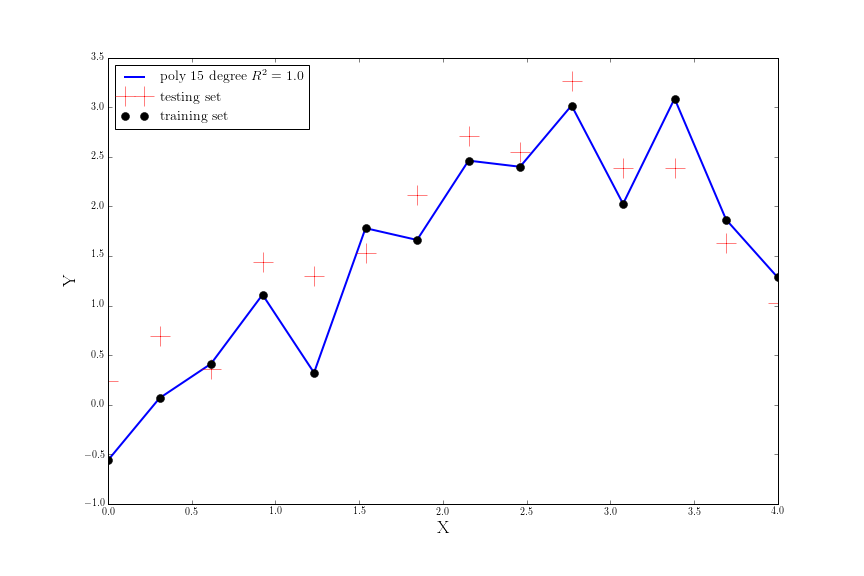

In [5]:

Image(filename='train_test.png') 

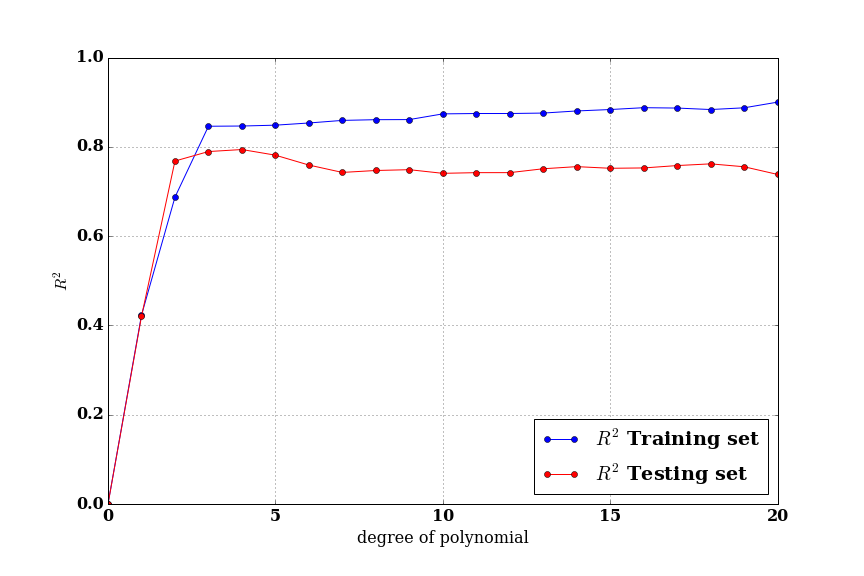

In [7]:
Image(filename='CrossValidation_poly.png') 

In [8]:
 

def polynomial_regression_fit(x, y, degrees):
    # Create the poly terms for x,x^2 .. 
    
    n= np.size(y)   # data size 
    x_poly = np.zeros([n, degrees]) # poly degree 
    
    
    for d in range(1, degrees +1):
        x_poly[:, d - 1] = np.power(x, d).flatten()  # adding terms 
    Xt=sm.add_constant(x_poly)
    model=sm.OLS(y,Xt)
    model_results=model.fit()
    return model_results, Xt


def polynomial_regression_predict(params, degrees, x):
    # # Create the poly terms for x,x^2 ..
    n = x.shape[0]
    x_poly = np.zeros([n, degrees])
    for d in range(1, degrees + 1):
        x_poly[:, d - 1] = np.power(x, d).flatten()
        
    Xt=sm.add_constant(x_poly,has_constant='add')
   
    # Predict y-vals
    y_pred = np.dot(params,Xt.T)
        
    return y_pred


---
## Validation Set Approach

- Randomly divide the data into two parts the training and validation.
- Fit the model on the training set and the fitted model is used to predict the response for the testing points. MSE (or $R^2$) is used a validation error. 


- Drawbacks 
  - Variability in the estimation of $R^2$ on test
  - Loosing data for fitting thus test error is exaggerated (see the extreme case of one observation is used to fit) 
  
  
---

---
## Validation Set Approach. The Auto data set





In [9]:
data = pd.read_csv('Auto.csv', sep=',')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### For the rest of the lecture we only consider horsepower as the single predictor

In [10]:


mpg=data['mpg'].values
horsepower=data['horsepower'].values

for k,h in enumerate(horsepower):
    x=type(float(h))
    
dt= np.vstack( [horsepower, mpg]).T

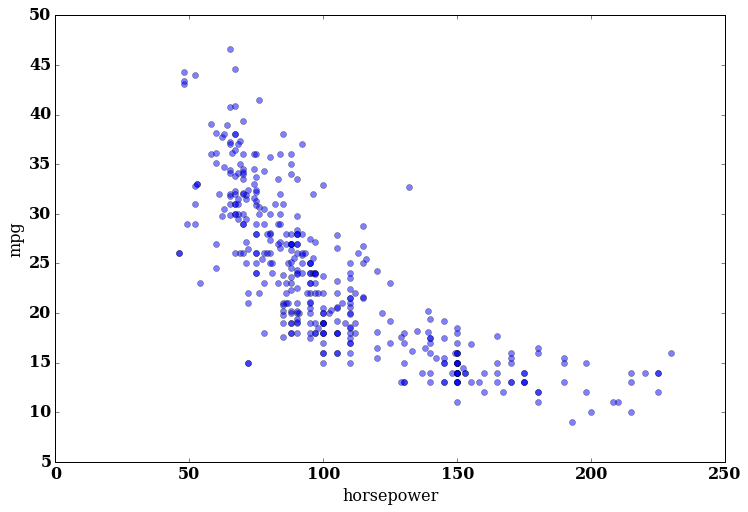

In [11]:
plt.figure(figsize=(12,8))
plt.plot(horsepower, mpg,  'bo', alpha=0.5)
horsepower.shape
plt.xlabel('horsepower'); plt.ylabel('mpg')

In [20]:
# FIT POLYNOMIALS 

N=mpg.shape[0]

degrees = 12
nsim=10

MSE_train = np.zeros([ degrees+1,nsim])
MSE_test = np.zeros([ degrees+1,nsim])



In [21]:

for i in np.arange(0,nsim):
    data_train=np.random.permutation(dt)[0:N/2]
    data_test=np.random.permutation(dt)[N/2:]

    X_train = data_train[:, 0:-1]
    Y_train = data_train[:, -1]

    X_test = data_test[:, 0:-1]
    Y_test = data_test[:,-1]

    

    for d in range(1, degrees +1):
        model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
        
        # Calculate MSE on train data 
        yp=polynomial_regression_predict(model_results.params, d, X_train)
        MSE_train[d,i]=((Y_train-yp)**2).mean()
        
        # Calculate MSE on test data 
        y_hat=polynomial_regression_predict(model_results.params, d, X_test)
        MSE_test[d,i]=((Y_test-y_hat)**2).mean()

MSE_train_mean = np.zeros([degrees+1,1])  
MSE_test_mean = np.zeros([degrees+1,1])  
MSE_test_std = np.zeros([degrees+1,1])  
MSE_train_std = np.zeros([degrees+1,1])  
dlist=np.zeros([degrees+1,1])  

for d in range(1, degrees +1):
        MSE_train_mean[d]= MSE_train[d,:].mean()
        MSE_test_mean[d]= MSE_test[d,:].mean()
        MSE_train_std[d] = MSE_train[d,:].std()
        MSE_test_std[d] = MSE_test[d,:].std()
        dlist[d] = d
        
        

(13, 1) (13, 10)


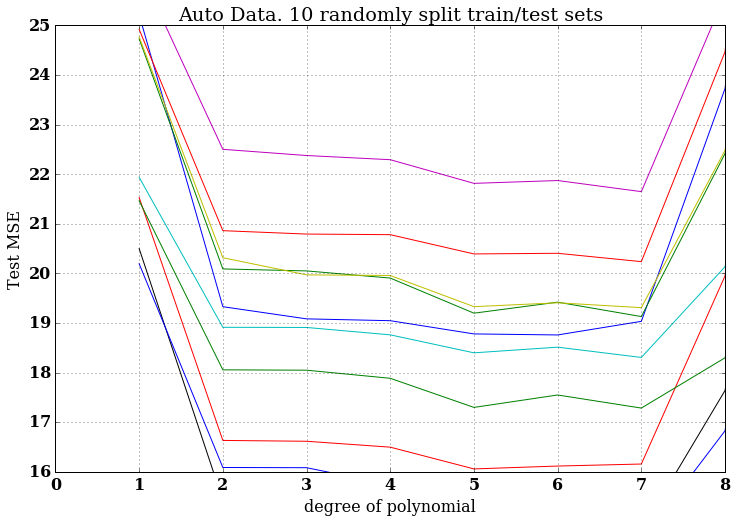

In [22]:


plt.figure(figsize=(12,8))
print dlist.shape, MSE_train.shape
plt.plot(dlist[1:], MSE_train[1:,:])
plt.ylim((16,25)); plt.xlim((0,8))
plt.xlabel('degree of polynomial'); plt.ylabel(r'Test MSE')
plt.xlabel('degree of polynomial'); plt.grid(); plt.title('Auto Data. 10 randomly split train/test sets')
plt.savefig('AutoVS.png')

### Try the same on max heart rate data. 

In [23]:

N =100
sigma =.4 
epsilon=np.random.normal(0,sigma,N)
Xmin=0
Xmax=4
X = np.linspace(Xmin,Xmax, N) 
Y = 0.2+.2*X + 0.8*X**2 - 0.2 *X**3+ epsilon

data_hr= np.vstack( [X,Y]).T


In [24]:
# 

degress=15
nsim=400

MSE_train = np.zeros([ degrees+1,nsim])
MSE_test = np.zeros([ degrees+1,nsim])


for i in np.arange(0,nsim):
    data_train=np.random.permutation(data_hr)[0:N/2]
    data_test=np.random.permutation(data_hr)[N/2:]

    X_train = data_train[:, 0:-1]
    Y_train = data_train[:, -1]

    X_test = data_test[:, 0:-1]
    Y_test = data_test[:,-1]


    

    for d in range(1, degrees +1):
        model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
        
        # Calculate MSE for TRAIN DATA
        yp=polynomial_regression_predict(model_results.params, d, X_train)
        MSE_train[d,i]=((Y_train-yp)**2).mean()
        

        y_hat=polynomial_regression_predict(model_results.params, d, X_test)
        MSE_test[d,i]=((Y_test-y_hat)**2).mean()
  
MSE_train_mean = np.zeros([degrees+1,1])  
MSE_test_mean = np.zeros([degrees+1,1])  
MSE_test_std = np.zeros([degrees+1,1])  
MSE_train_std = np.zeros([degrees+1,1])  
dlist=np.zeros([degrees+1,1])  

for d in range(1, degrees +1):
        MSE_train_mean[d]= MSE_train[d,:].mean()
        MSE_test_mean[d]= MSE_test[d,:].mean()
        MSE_train_std[d] = MSE_train[d,:].std()
        MSE_test_std[d] = MSE_test[d,:].std()
        dlist[d] = d

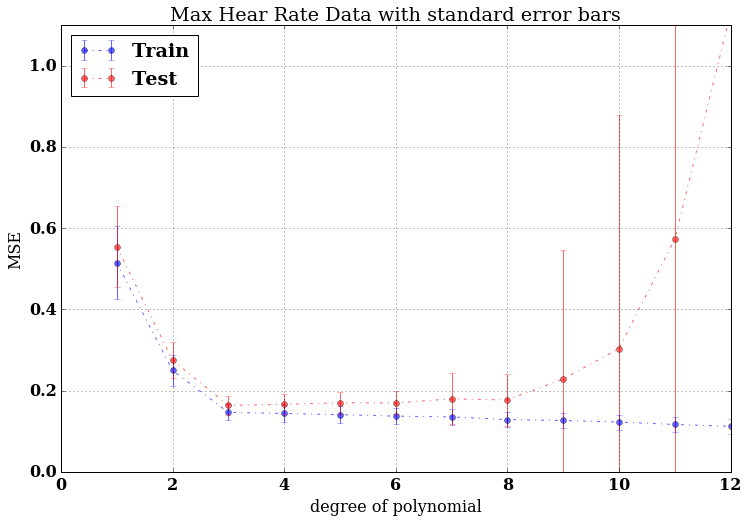

In [25]:

plt.figure(figsize=(12,8))
h1=plt.errorbar(dlist[1:],MSE_train_mean[1:], yerr=MSE_train_std[1:],  fmt='b-.o', alpha=0.6, label='Train')
h2=plt.errorbar(dlist[1:],MSE_test_mean[1:], yerr=MSE_test_std[1:], fmt='r-.o',alpha=0.6, label='Test')

plt.ylim((0,1.1)); plt.xlim((0,12))
plt.xlabel('degree of polynomial'); plt.ylabel(r'MSE')
plt.xlabel('degree of polynomial'); 
plt.legend(loc='best', handles =[h1, h2])
plt.title('Max Hear Rate Data with standard error bars')
plt.grid()

---
## Validation Set Approach (cont)

- Validation estimate of the test error rate can be highly variable. That depends on which observations are included in the training set and which observations are included in the validation set.
- In the validation approach, we only use a subset of the observations to fit the model
    $\rightarrow$ Overestimate the test error rate compared to a fit of the whole dataset
    
---- 


----

# Outline 
-  Review and where we are heading  
- Cross Validation 
    - Validation Set
    - ** Leave one out **
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  


--- 
## Cross Validation: Leave one out cross validation 

- Like the validation set but use n-1 to fit and test on 1 (sub-slide) 

<img src="Images/Slide3.png" alt="" style="width:604px;">

<img src="Images/Slide4.png" alt="" style="width:604px;">

--- 
- Say we leave the i-th point out,  the validation error is
$$ {\rm MSE}_k = (\hat{y}_k - y_k)^2$$


- Average the errors from all $n$ times
$$ CV_n = \frac{1}{n} \sum_i {\rm MSE}_i $$


LOOCV is more accurate than using validation set, since we are using $n-1$ data points as oppose to some fraction of n (n/2).
- No randomness, always the same results 
- Could be computationally demanding since we need to fit the model $n$ times, but there is a magic trick

$$ CV_n = \frac{1}{n} \sum_i \left(\frac{y_i-\hat{y}_i}{1-h_i}\right)^2 $$

where $h_i$ is the leverage defined as:

$$ h_i = \frac{1}{n}+ \frac{(x_i-\bar{x})^2}{\sum_j (x_j-\bar{x})^2} $$ 

---- 
Note: General method to be used with other methods such as logistic regression 

In [28]:
## Now do cross validation k=1-fold
def AutoLOO(dt):
    K= dt.shape[0]
    step = 1
    nsim = 1
    degrees= 7

    plt.figure(figsize=(12,8))

    MSE_train = np.zeros([ degrees+1,K])
    MSE_test = np.zeros([ degrees+1,K])
    MSE_train_K = np.zeros([ degrees+1,nsim])
    MSE_test_K = np.zeros([ degrees+1,nsim])



    for j in np.arange(0,nsim):
        #dt=np.random.permutation(dt)[0:N]

        for i in np.arange(0,K):

            data_train = np.concatenate( (dt[:i*step] , dt[(i+1)*step:-1]))
            data_test = dt[i*step:(i+1)*step]

            X_train = data_train[:, 0:-1]
            Y_train = data_train[:, -1]

            X_test = data_test[:, 0:-1]
            Y_test = data_test[:,-1]
            

            for d in range(1, degrees +1):
                model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
                yp=polynomial_regression_predict(model_results.params, d, X_train)           
                MSE_train[d,i]= ((Y_train-yp)**2).mean()
 
                y_hat=polynomial_regression_predict(model_results.params, d, X_test)
                MSE_test[d,i]=((Y_test-y_hat)**2) # NO NEED FOR MEAN 

        
        for d in range(1, degrees +1):
            MSE_test_K[d,j] = MSE_test[d,:].mean()
            MSE_train_K[d,j] = MSE_train[d,:].mean() 
            #print  MSE_test[d,:].mean() , MSE_test[d,:].std(), MSE_test.shape

        dlist=np.linspace(1, MSE_test_K.shape[0],MSE_test_K.shape[0]-1 )
        
        plt.plot(dlist,MSE_test_K[1:, j], 'b-o', label='test')
        plt.legend()
        plt.xlabel('degree of polynomial');plt.title('Auto Data LOO') 
        plt.ylabel('MSE')



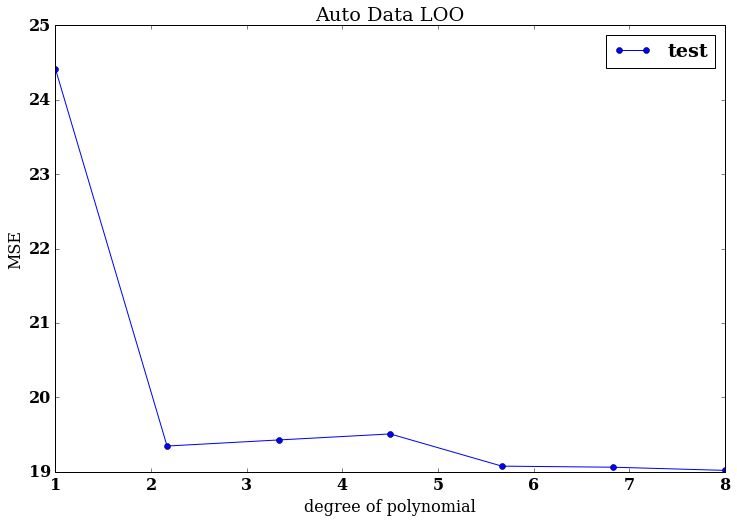

In [29]:
AutoLOO(dt)

----

# Outline 
-  Review and where we are heading  
- Cross Validation 
    - Validation Set
    - Leave one out 
    - ** k-Fold cross validation **
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  


--- 
## Cross Validation: k-Fold

- Split data into folds. Use one for validation the rest for training and repeat k times
- Computationally efficient 





<img src="k_FOLD/Slide1.jpg" alt="" style="width:604px;">


<img src="k_FOLD/Slide2.jpg" alt="" style="width:604px;">


### k-Fold CV (cont) 

Comparing the Auto dataset 

In [37]:
## Now do cross validation k-fold


def AutoKfold(dt, K):
    step = np.round(1.0*N/K )
    nsim = 8
    degrees= 9

    plt.figure(figsize=(12,8))

    MSE_train = np.zeros([ degrees+1,K])
    MSE_test = np.zeros([ degrees+1,K])
    MSE_K = np.zeros([ degrees+1,nsim])



    for j in np.arange(0,nsim):
        dt=np.random.permutation(dt)[0:N]

        for i in np.arange(0,K):
            data_train = np.concatenate( (dt[:i*step] , dt[(i+1)*step:-1]))
            data_test = dt[i*step:(i+1)*step]


            X_train = data_train[:, 0:-1]
            Y_train = data_train[:, -1]

            X_test = data_test[:, 0:-1]
            Y_test = data_test[:,-1]

            for d in range(1, degrees +1):
                model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
                yp=polynomial_regression_predict(model_results.params, d, X_train)
                MSE_train[d,i]=((Y_train-yp)**2).mean()
                
                y_hat=polynomial_regression_predict(model_results.params, d, X_test)
                MSE_test[d,i]=((Y_test-y_hat)**2).mean()


        for d in range(1, degrees +1):
            MSE_K[d,j] = MSE_test[d,:].mean()

        plt.title('Auto Data k-Fold'); plt.xlabel('Polynomial degree'); plt.ylabel('MSE')
        plt.plot(MSE_K[1:, j]); plt.grid()
        plt.ylim((16,25))


/Users/pavlos/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/pavlos/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


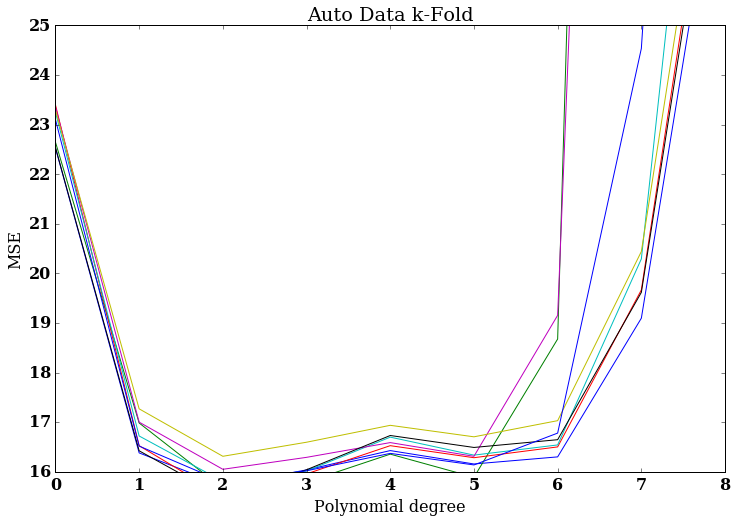

In [38]:
AutoKfold(dt, 10)


### Compared to the randomly split train/test sets

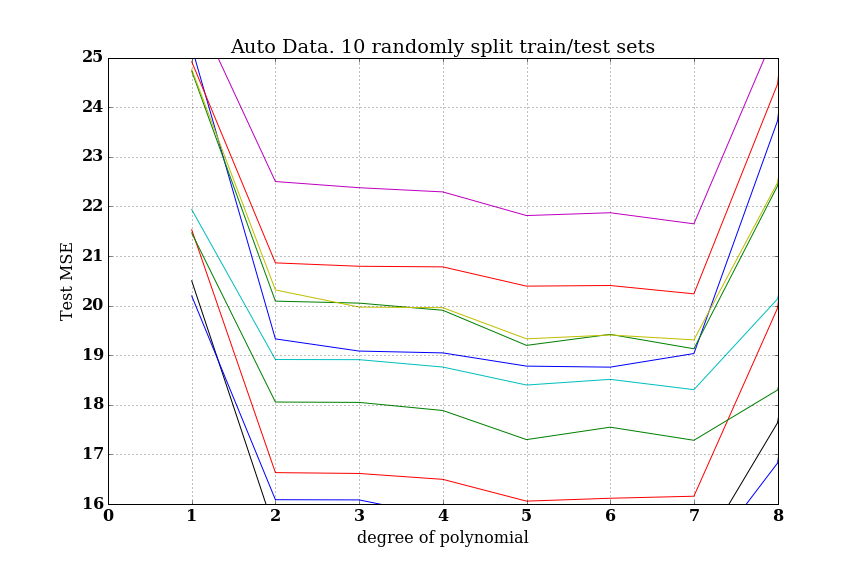

In [39]:
Image('AutoVS.png')

### K-Fold vs LOO
 

LOOCV has  higher variance than does k-fold CV. This is because LOOCV, in effect is averaging the outputs of n fitted models, each of which is trained on an almost identical set of observations.

<img src="LOOKFold_comparison.png">

--

LOOCV is black, 10-fold is orange, true in blue. Three synthetic data sets. 

----

# Outline 
-  Review and where we are heading  
- Cross Validation 
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - ** Bootstrapping **
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  



## Bootstrap 

- A very simple 

widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method





<img src="Images/Slide5.png" alt="" style="width:604px;">

<img src="Images/Slide7.png" alt="" style="width:604px;">


In [40]:
def plotSE():

    # Load train set
    data = pd.read_csv("maxheartrate.csv") 

    x = data['age'].values
    y = data['maxheartrate'].values

 
    # Size of the data set
    n = x.shape[0]


    # No. of subsamples
    num_samples = 200

    ### Linear regression 

    # Create a n  array to store coefficients for all subsamples
    coefs_a = np.zeros((num_samples, 2))


    for i in range(num_samples):

        # Generate a random subsample of data points
        # This is the bootstrap 
        # 
        perm =np.random.randint(low=0, high=n, size=n) # Generate a list of indices 0 to n and permute it
        x_subsample = x[perm] 
        y_subsample = y[perm] 

        # Fit linear regression model on subsample
        #
        xt= sm.add_constant(x_subsample)
        model = sm.OLS( y_subsample, xt)
        model_results= model.fit()

        # Store the coefficient for the model we obtain
        coefs_a[i, :] = model_results.params


    # Plot histogram of coefficients, and report their confidence intervals 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    
    # HOW DOES IT COMPARED TO STANDARD CONF INTERVAL WITHOUT BOOTSTRAP ?
    xt = sm.add_constant(x)
    model=sm.OLS(y,xt)
    model_res=model.fit()
    print "Theoretical estimate: SE beta_0", np.sqrt(model_results.mse_resid*(1.0/n+ x.mean()**2/np.sum( (x-x.mean())**2)))
    print "Theoretical estimate: SE beta_1", np.sqrt(model_results.mse_resid/np.sum( (x-x.mean())**2))
    
    # Repeat for each coefficient (this is just the confidence intervals )
    for j in range(2):
        # Compute mean for the j-th coefficent from subsamples
        coef_j_mean = np.mean(coefs_a[:, j])
        print coef_j_mean
        # Compute confidence interval at 95% confidence level (use formula!)
        conf_int_left = np.percentile(coefs_a[:, j], 2.5)
        conf_int_right = np.percentile(coefs_a[:, j], 97.5)
        print('Bootstrap: SE'+ r' beta_'+str(j) +' =',(coef_j_mean-conf_int_left) /2) 
       
        # Plot histogram of coefficient values
        axes[j].hist(coefs_a[:, j], alpha=0.5)

        # Plot vertical lines at mean and left, right extremes of confidence interval
        axes[j].axvline(x = coef_j_mean, linewidth=3)
        axes[j].axvline(x = conf_int_left, linewidth=1, c='r')
        axes[j].axvline(x = conf_int_right, linewidth=1, c='r')

        # Set plot labels
        axes[j].set_title('[' + str(round(conf_int_left, 4)) 
                          + ', ' 
                          + str(round(conf_int_right, 4)) + ']')
        axes[j].set_xlabel('Predictor ' + str(j + 1))
        axes[j].set_ylabel('Frequency')

    plt.show()
    
    

Theoretical estimate: SE beta_0 0.542844939791
Theoretical estimate: SE beta_1 0.00985576330313
210.078271591
('Bootstrap: SE beta_0 =', 0.53085806869015073)
-0.697417213453
('Bootstrap: SE beta_1 =', 0.0087226209921538733)


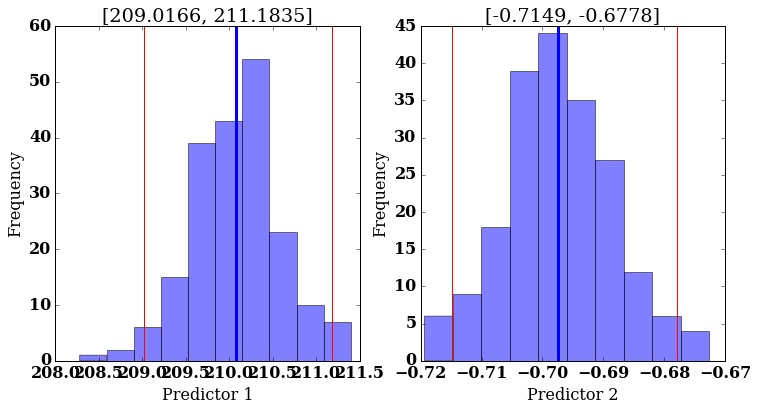

In [42]:
plotSE()

----

# Outline 
-  Review and where we are heading  
- Cross Validation  
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- ** Shrinkage Methods ** GO TO LECTURE 7
    - [Ridge Regression]
    - [Lasso]  

---  
